In [85]:
from pathlib import Path

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
from tqdm.auto import tqdm

In [86]:
timings = pd.read_csv(Path("S:\E_ResearchData\evdplanner\Test\evd_times.csv"))

total_times = timings.loc[timings["substage"] == "total"]

print(f"Mean time: {total_times['time'].mean():.4f}s")
print(f"std: {total_times['time'].std():.4f}s")
print(f"Median time: {total_times['time'].median():.4f}s")
print(f"95CI: {total_times['time'].quantile(0.025):.4f}s - {total_times['time'].quantile(0.975):.4f}s")
print(f"Max time: {total_times['time'].max():.4f}s")
print(f"Min time: {total_times['time'].min():.4f}s")

Mean time: 13.4100s
std: 2.4197s
Median time: 13.7215s
95CI: 8.1278s - 17.1458s
Max time: 20.0380s
Min time: 5.9738s


In [87]:
read_times = timings[timings["main stage"] == "read"].groupby("substage")["time"].mean()
read_std = timings[timings["main stage"] == "read"].groupby("substage")["time"].std()
write_times = timings[timings["main stage"] == "write"].groupby("substage")["time"].mean()
write_std = timings[timings["main stage"] == "write"].groupby("substage")["time"].std()
processing_times = timings[timings["main stage"] == "processing"].groupby("substage")["time"].mean()
processing_std = timings[timings["main stage"] == "processing"].groupby("substage")["time"].std()
other_times = timings[(timings["main stage"] == "common") & (timings["substage"] != "total")].groupby("substage")["time"].mean()

In [88]:
def get_colors(colormap: str, n_colors: int, start: float = 0.25, end: float = 0.75) -> list:
    return [cm.get_cmap(colormap)(x) for x in np.linspace(start, end, n_colors)]

C:\Users\mboer41\AppData\Local\Temp\ipykernel_24912\773804937.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return [cm.get_cmap(colormap)(x) for x in np.linspace(start, end, n_colors)]


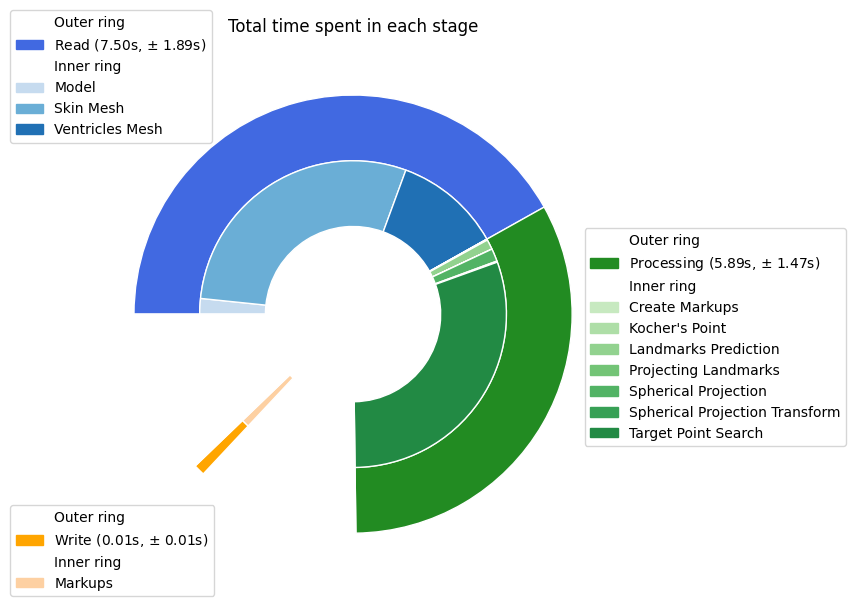

In [89]:
fig, ax = plt.subplots(figsize=(10, 6))

size = 0.3
counterclock = False
start_angle = 180

expanded_write = write_times.sum() * 10.0

padding = (np.sum([read_times.sum(), processing_times.sum(), expanded_write]) / 3) - expanded_write
padding /= 2

ax.pie(
    [read_times.sum(), processing_times.sum(), padding, expanded_write, padding],
    startangle=start_angle,
    colors=["royalblue", "forestgreen", "white", "orange", "white"],
    radius=1,
    wedgeprops=dict(width=size, edgecolor="w"),
    counterclock=counterclock,
)
ax.pie(
    list(read_times.values) + list(processing_times.values) + [padding] + list(write_times.values * 10) + [padding],
    startangle=start_angle,
    colors=get_colors("Blues", len(read_times)) + get_colors("Greens", len(processing_times)) + ["white"] + get_colors("Oranges", len(write_times)) + ["white"],
    radius=1 - size,
    wedgeprops=dict(width=size, edgecolor="w"),
    counterclock=counterclock,
)
ax.set(title="Total time spent in each stage")

read_handles = [
    mpatches.Patch(color="none", label="Outer ring", fill=False),
    mpatches.Patch(color="royalblue", label=f"Read ({read_times.sum():.2f}s, $\\pm$ {read_std.sum():.2f}s)"),
    mpatches.Patch(color="none", label="Inner ring", fill=False)
]
for i, (key, value) in enumerate(read_times.items()):
    read_handles.append(mpatches.Patch(color=get_colors("Blues", len(read_times))[i], label=f"{key}"))
fig.legend(
    handles=read_handles,
    loc="upper left",
    bbox_to_anchor=(0.15, 1.0),
    ncol=1,
)

processing_handles = [
    mpatches.Patch(color="none", label="Outer ring", fill=False),
    mpatches.Patch(color="forestgreen", label=f"Processing ({processing_times.sum():.2f}s, $\\pm$ {processing_std.sum():.2f}s)"),
    mpatches.Patch(color="none", label="Inner ring", fill=False)
]
for i, (key, value) in enumerate(processing_times.items()):
    processing_handles.append(mpatches.Patch(color=get_colors("Greens", len(processing_times))[i], label=f"{key}"))
fig.legend(
    handles=processing_handles,
    loc="lower right",
    bbox_to_anchor=(1.0, 0.25),
    ncol=1,
)

write_handles = [
    mpatches.Patch(color="none", label="Outer ring", fill=False),
    mpatches.Patch(color="orange", label=f"Write ({write_times.sum():.2f}s, $\\pm$ {write_std.sum():.2f}s)"),
    mpatches.Patch(color="none", label="Inner ring", fill=False)
]
for i, (key, value) in enumerate(write_times.items()):
    write_handles.append(mpatches.Patch(color=get_colors("Oranges", len(write_times))[i], label=f"{key}"))
fig.legend(
    handles=write_handles,
    loc="lower left",
    bbox_to_anchor=(0.15, 0.0),
    ncol=1,
)

plt.tight_layout()
plt.show()

In [90]:
timings["mainsub"] = timings["main stage"].apply(lambda x: x.capitalize()) + ": " + timings["substage"]

# drop rows with "common" main stage
# timings = timings[timings["main stage"] != "common"]

steps_order = [
    "Read: Model",
    "Read: Skin Mesh",
    "Processing: Spherical Projection",
    "Processing: Spherical Projection Transform",
    "Processing: Landmarks Prediction",
    "Processing: Projecting Landmarks",
    "Processing: Kocher's Point",
    "Read: Ventricles Mesh",
    "Processing: Target Point Search",
    "Processing: Create Markups",
    "Write: Markups",
]

patients = timings["patient"].unique()
for patient in patients:
    summed_time = 0.0
    for step in steps_order:
        step_time = timings.loc[(timings["patient"] == patient) & (timings["mainsub"] == step), "time"].sum()
        summed_time += step_time
        timings.loc[(timings["patient"] == patient) & (timings["mainsub"] == step), "cumulative_time"] = summed_time

timings["step_idx"] = timings.loc[(timings["main stage"] != "common"), "mainsub"].apply(lambda x: steps_order.index(x))
timings = timings.sort_values(by=["patient", "step_idx"])
timings.head()

,patient,main stage,substage,time,mainsub,cumulative_time,step_idx
0,Augmedit DisiorValidation GBM 1,common,total,10.187914,Common: total,NaN,NaN
3036,Augmedit DisiorValidation GBM 1,common,total,10.170526,Common: total,NaN,NaN
6072,Augmedit DisiorValidation GBM 1,common,total,10.817666,Common: total,NaN,NaN
1,Augmedit DisiorValidation GBM 1 run 0,read,Model,0.453223,Read: Model,0.453223,0.0
2,Augmedit DisiorValidation GBM 1 run 0,read,Skin Mesh,4.416695,Read: Skin Mesh,4.869919,1.0


[Text(0.5, 0, 'Cumulative Time (s)'), Text(0, 0.5, 'Step')]

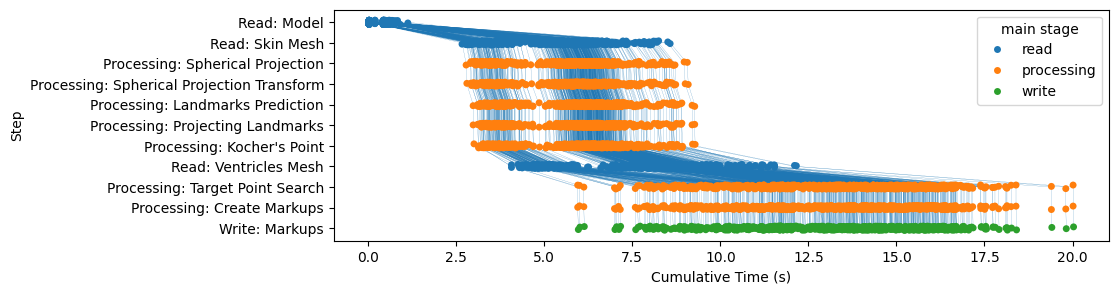

In [91]:
fig, ax = plt.subplots(figsize=(10, 3))
sns.stripplot(
    data=timings[timings["main stage"] != "common"],
    x="cumulative_time",
    y="mainsub",
    order=steps_order,
    hue="main stage",
    ax=ax,
)

sns.lineplot(
    data=timings[timings["main stage"] != "common"].sort_values(["patient", "step_idx"]),
    x="cumulative_time",
    y="step_idx",
    units="patient",
    estimator=None,
    ax=ax,
    legend=False,
    lw=0.125,
)

ax.set(xlabel="Cumulative Time (s)", ylabel="Step")

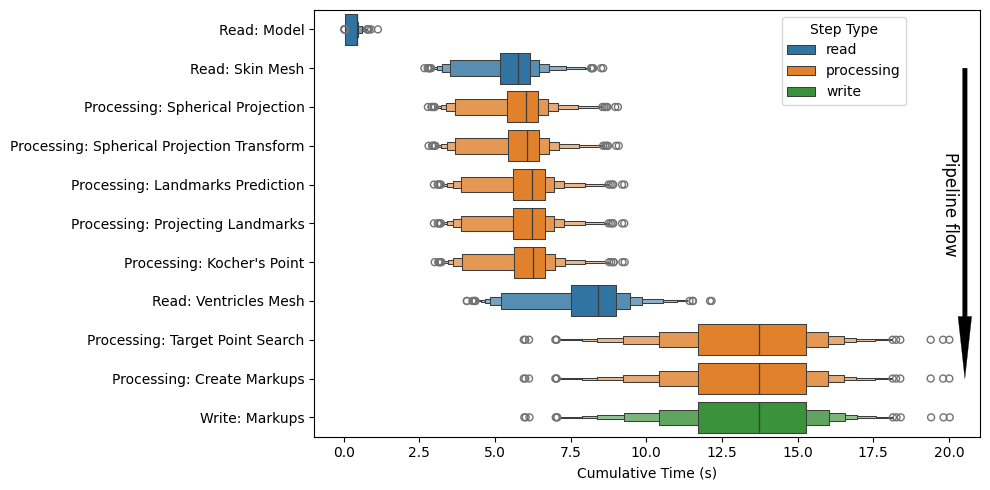

In [92]:
fig, ax = plt.subplots(figsize=(10, 5))

# sns.lineplot(
#     data=timings[timings["main stage"] != "common"].sort_values(["patient", "step_idx"]),
#     x="cumulative_time",
#     y="step_idx",
#     units="patient",
#     estimator=None,
#     ax=ax,
#     legend=False,
#     lw=0.1,
#     alpha=0.25,
#     color="k",
# )

sns.boxenplot(
    data=timings[timings["main stage"] != "common"],
    x="cumulative_time",
    y="mainsub",
    order=steps_order,
    hue="main stage",
    ax=ax,
)

ax.legend(title="Step Type", loc="upper right", bbox_to_anchor=(0.9, 1.0))

ax.set(xlabel="Cumulative Time (s)", ylabel="")
ax.add_patch(
    plt.Arrow(
        x=timings.loc[timings["mainsub"] == "Write: Markups", "cumulative_time"].max() + 0.5,
        y=1,
        dx=0,
        dy=len(steps_order) - 3,
        color="k",
        width=0.75,
        lw=0.2,
    )
)
ax.text(
    x=timings.loc[timings["mainsub"] == "Write: Markups", "cumulative_time"].max() - 0.0,
    y=(len(steps_order) - 3) / 2 + 0.5,
    s="Pipeline flow",
    ha="center",
    va="center",
    rotation=-90,
    fontsize=12,
)

plt.tight_layout()
plt.show()

In [95]:
print(f"Number of observations: {len(timings[timings['substage'] == 'total'])}")
print(timings.groupby("mainsub")["time"].mean())

Number of observations: 759
mainsub
Common: total                                 13.409980
Processing: Create Markups                     0.000045
Processing: Kocher's Point                     0.018184
Processing: Landmarks Prediction               0.188309
Processing: Projecting Landmarks               0.000812
Processing: Spherical Projection               0.240326
Processing: Spherical Projection Transform     0.021467
Processing: Target Point Search                5.423242
Read: Model                                    0.292735
Read: Skin Mesh                                5.183847
Read: Ventricles Mesh                          2.019147
Write: Markups                                 0.014746
Name: time, dtype: float64
